<a href="https://colab.research.google.com/github/maryam-sabet/KFold_DeepLearning_BinaryClassification_using_EnsembleMethod/blob/main/EfficientNetV2B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Change tensorflow version**

In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 349.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting un

# **Libraries**

In [ ]:
import glob
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet169,Xception,MobileNet,MobileNetV2,NASNetMobile,EfficientNetB0,DenseNet121,EfficientNetV2B0,ResNet50V2
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input,Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint , CSVLogger , LearningRateScheduler
from sklearn.metrics import precision_score , recall_score , f1_score , confusion_matrix , ConfusionMatrixDisplay ,classification_report


In [ ]:
tf.__version__

'2.9.1'

# **Loading data**

In [ ]:
data = np.load("/content/drive/MyDrive/paper/data.npy",allow_pickle=True)
label = np.load("/content/drive/MyDrive/paper/label.npy",allow_pickle=True)


In [ ]:
random.seed(1254)
combined = list(zip(data, label))
random.shuffle(combined)


data, label = zip(*combined)
label = np.array(label)
data = np.array(data)

<ipython-input-10-66914fa876a0>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [ ]:
# Label binarizing
lb = preprocessing.LabelBinarizer()

labels = lb.fit_transform(label)
label_category = to_categorical(labels , num_classes=2)

In [ ]:
#resize input images
Data =list()
for item in data:
  img = cv2.resize(item , (224,224) , cv2.INTER_NEAREST )
  Data.append(img)

Data = np.array(Data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Data, label_category, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape ,y_train.shape ,X_test.shape , y_test.shape  )

(1120, 224, 224, 3) (1120, 2) (280, 224, 224, 3) (280, 2)


# **Models**

In [ ]:
model_save = ModelCheckpoint("/content/drive/MyDrive/paper/ensemble-learning/EfficientNetV2B0.h5" , save_best_only=True , verbose=2 , monitor="val_accuracy" , mode="max" )

In [ ]:
base_model = EfficientNetV2B0(weights="imagenet", include_top=False , input_tensor=Input(shape=(224,224,3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatting")(x)
x = Dense(128, activation='relu')(x)
x= Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

24274472/24274472 [==============================] - 0s 0us/step


# **preprocessing for fit model and fit**

In [ ]:
csv_loger = CSVLogger("/content/drive/MyDrive/paper/ensemble-learning/EfficientNetV2B0.csv" , append=True)

In [ ]:
def set_decay(epoch):
  initAlpha =0.0008
  factor = 0.9
  dropEvery = 25
  aplpha = initAlpha * (factor**np.floor((1+epoch) / dropEvery))
  return float(aplpha)

In [ ]:
optim = keras.optimizers.Adam(learning_rate = 0.0008)
model.compile(optim , loss="categorical_crossentropy" , metrics=["accuracy"])


In [ ]:
batch_size = 8
TrainStep = len(X_train) / batch_size
ValStep = len(X_test) / batch_size

In [ ]:
x_train=X_train/255.0
x_test=X_test/255.0

In [ ]:
# generating with functions
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train = datagen.flow(x_train, y_train, batch_size=8)

In [ ]:
H = model.fit(train , epochs=15, callbacks=[model_save, csv_loger, LearningRateScheduler(set_decay)]
                        , validation_data = (x_test, y_test),shuffle=True )

Epoch 1/15
140/140 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9295
Epoch 1: val_accuracy improved from -inf to 0.72857, saving model to /content/drive/MyDrive/paper/ensemble-learning/EfficientNetV2B0.h5
140/140 [==============================] - 43s 158ms/step - loss: 0.1977 - accuracy: 0.9295 - val_loss: 0.5279 - val_accuracy: 0.7286 - lr: 8.0000e-04
Epoch 2/15
140/140 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9357
Epoch 2: val_accuracy improved from 0.72857 to 0.95000, saving model to /content/drive/MyDrive/paper/ensemble-learning/EfficientNetV2B0.h5
140/140 [==============================] - 21s 147ms/step - loss: 0.1758 - accuracy: 0.9357 - val_loss: 0.1790 - val_accuracy: 0.9500 - lr: 8.0000e-04
Epoch 3/15
140/140 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9643
Epoch 3: val_accuracy did not improve from 0.95000
140/140 [==============================] - 18s 130ms/step - loss: 0.1228 - accuracy:

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(121)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.subplot(122)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(['tarin', "validation"] , loc="upper left")
plt.show()

NameError: ignored

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/paper/ensemble-learning/EfficientNetV2B0.h5")

In [ ]:
#train
model.evaluate(x_train,y_train)

35/35 [==============================] - 3s 52ms/step - loss: 0.0055 - accuracy: 0.9991


[0.005450430326163769, 0.9991071224212646]

In [ ]:
#test
model.evaluate(x_test, y_test)

9/9 [==============================] - 2s 58ms/step - loss: 0.0035 - accuracy: 1.0000


[0.003492614021524787, 1.0]

In [ ]:
prediction=model.predict(x_test)

9/9 [==============================] - 2s 56ms/step


In [ ]:
prediction=np.argmax(prediction,-1)
y_test=np.argmax(y_test,-1)

In [ ]:
precision = precision_score(y_test , prediction ,  average="weighted")
print(precision*100)

100.0


In [ ]:
recal = recall_score(y_test , prediction ,  average="weighted")
print(recal*100)

100.0


In [ ]:
f1 = f1_score(y_test , prediction ,  average="weighted")
print(f1*100)

100.0


In [ ]:
print(classification_report(y_test , prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       143

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [ ]:
confusion_matrix(y_test , prediction)

array([[137,   0],
       [  0, 143]])

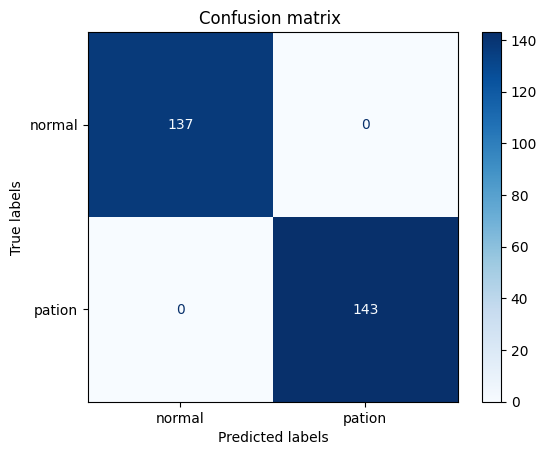

In [ ]:
cm=confusion_matrix(y_test , prediction)
target_names = ["normal" , "pation"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.title('Confusion matrix ')
plt.ylabel("True labels")
plt.show()